In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import networkx as nx
import matplotlib.pyplot as plt
import torch
import torch_geometric
import matplotlib.colors as mcolors
import heapq
from torch_geometric.datasets import Planetoid
import random


%matplotlib inline

## The first step from previous feedback is to *rigorously define importance*:

**How I decided to define it was to:**
1. Give weights to certain journals: Create a scoring system where high-impact journals contribute more to a paper's importance score.
2. Normalize citations by age: Use a decay function to give more recent citations slightly higher weight.
3. Altmetric Scores -- to account for online mentions, social media impact, and other non-traditional citation metrics.
4. Author Influence: Weigh papers based on the influence and citation history of the authors ---> Use metrics like h-index or g-index of the authors.
5. Paper Content: Use text analysis to determine the novelty and contribution of the paper. More specifically, Analyze the abstract, introduction, and conclusion to assess the paper's impact on future research.

On attempt 1, I intend on using a HDBSCAN. 


### Step by step todo:

#### Prototype the Importance Scoring:

Develop a prototype that calculates importance scores based on the proposed 5 metrics.

Validate the scores with a small dataset.
Cluster and Visualize:

#### Use HDBSCAN to cluster the embedded research papers.
Visualize the clusters and analyze their coherence.
Develop Graphs and MSAs:

#### Create directed graphs for each cluster.
Implement the Chu-Liu/Edmonds/Bock Algorithm to find the MSA.
Feedback and Iteration:

#### Gather feedback from peers or domain experts.
Iterate on the scoring and clustering methodology based on the feedback.

# Step 1: Prototype the Importance Scoring:
## Part 1: Embedding

Use techniques like BERT embeddings to capture the semantic meaning of paper metadata (title, abstract, authors, etc.).
Perform dimensionality reduction using PCA or t-SNE for visualization and clustering.

Using the same dataset as main.ipynb

In [2]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')

data = dataset[0]
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


Processing...
Done!


In [6]:
from torch_geometric.datasets import Planetoid
from transformers import BertTokenizer, BertModel
import torch

# Load the dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

# Extraction Function
def extract_metadata(data):
    # TODO: actually finish this out
    metadata_list = []
    for i in range(data.num_nodes):

        # Find indices of non-zero features

        word_indices = (data.x[i] > 0).nonzero(as_tuple=True)[0].tolist()
        

        # fix this stuff later

        title = f"Paper {i} on topics: " + ", ".join([str(idx) for idx in word_indices[:10]])  # First 10 
        metadata_list.append(title)
    return metadata_list

metadata_list = extract_metadata(data)
print(metadata_list[:5])  # Print first 5 for error handling

# Error Handling: Makes sure that all the items are a list of strings
if not all(isinstance(item, str) for item in metadata_list):
    raise ValueError("All items in metadata_list should be strings.")

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Tokenize and get embeddings
def get_bert_embeddings(text_list):
    inputs = tokenizer(text_list, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        
    # Use the mean of the last hidden state as the embedding
    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings

embeddings = get_bert_embeddings(metadata_list)

# Convert embeddings to torch tensor and assign to data.x
data.x = embeddings
print(data.x.shape)

['Paper 0 on topics: 19, 81, 146, 315, 774, 877, 1194, 1247, 1274', 'Paper 1 on topics: 19, 88, 149, 212, 233, 332, 336, 359, 472, 507', 'Paper 2 on topics: 19, 89, 128, 322, 381, 480, 507, 551, 647, 702', 'Paper 3 on topics: 93, 283, 359, 402, 452, 470, 507, 540, 715, 721', 'Paper 4 on topics: 3, 81, 337, 586, 698, 747, 819, 860, 893, 1060']
torch.Size([2708, 768])


### Note: Change the dataset from the last one

# Step 1: Prototype the Importance Scoring:
## Part 2: Perform dimensionality reduction using PCA or t-SNE for visualization and clustering.

Explained variance ratio by PCA components: [0.3749367  0.12436286 0.04625985 0.03361103 0.02776284 0.02060546
 0.01884085 0.01695071 0.01568128 0.01463915 0.01356734 0.01221537
 0.01143771 0.01126015 0.01081094 0.00977026 0.00895915 0.00874193
 0.00813002 0.00765923 0.00720133 0.00673522 0.00635091 0.00583829
 0.00547681 0.00511928 0.00496145 0.00453068 0.00446799 0.00430633
 0.00417306 0.00376525 0.00364783 0.00339227 0.00333058 0.00313211
 0.00296525 0.00285283 0.00273075 0.00261735 0.00241192 0.00238191
 0.00237013 0.00226658 0.00213944 0.0020422  0.00197701 0.00191799
 0.00187752 0.00175997]
Cumulative explained variance: 0.9049429893493652
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2708 samples in 0.000s...
[t-SNE] Computed neighbors for 2708 samples in 0.275s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2708
[t-SNE] Computed conditional probabilities for sample 2000 / 2708
[t-SNE] Computed conditional probabilities for sample 2708 / 2708
[t-SNE

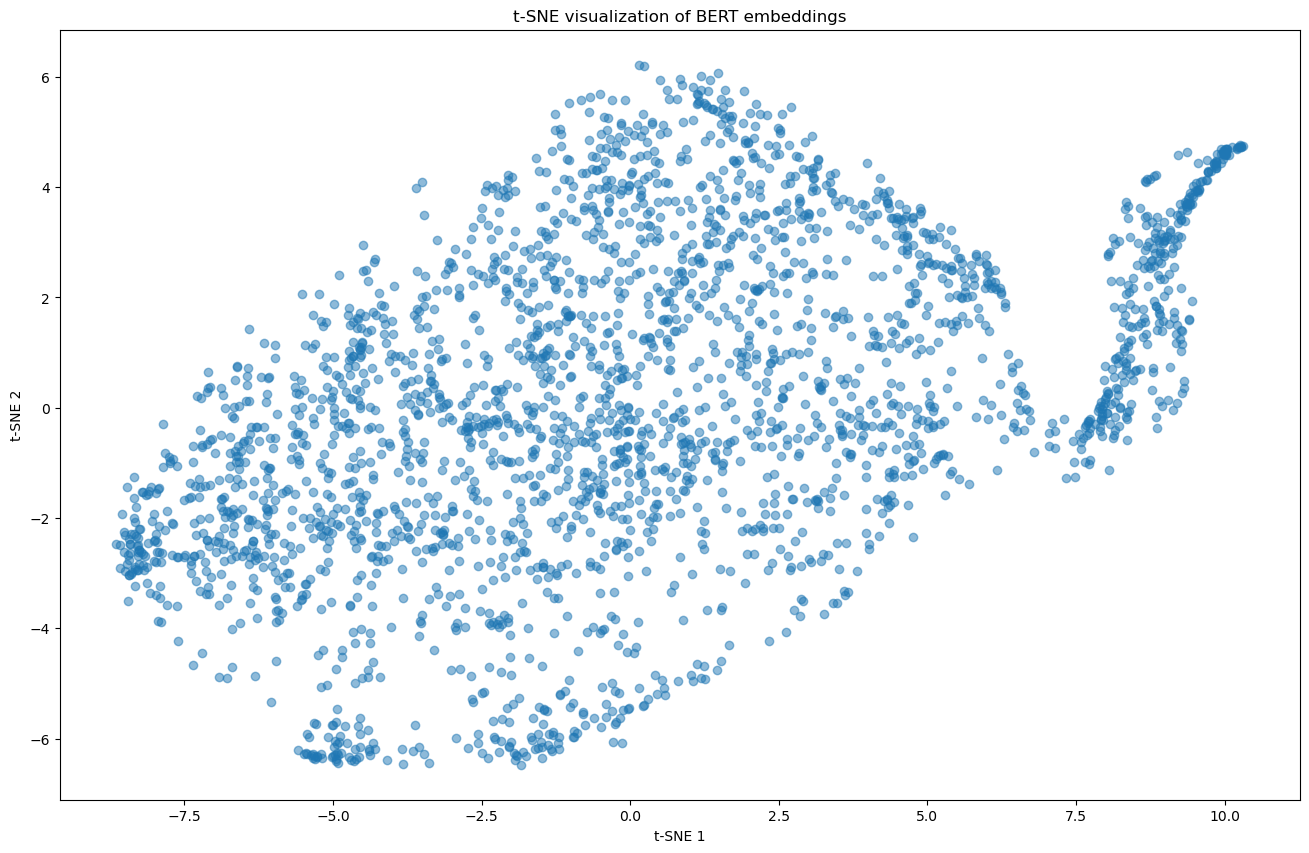

  Obtaining dependency information for hdbscan from https://files.pythonhosted.org/packages/92/84/5ed86936a26efe0baf8d26e8c4d624eb10275bf77ff5382591748e6f637c/hdbscan-0.8.36-cp311-cp311-macosx_10_9_universal2.whl.metadata
  Obtaining dependency information for cython<3,>=0.27 from https://files.pythonhosted.org/packages/7e/26/9d8de10005fedb1eceabe713348d43bae1dbab1786042ca0751a2e2b0f8c/Cython-0.29.37-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.6 MB/s eta 0:00:0031m11.0 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.5/989.5 kB 11.3 MB/s eta 0:00:0031m12.2 MB/s eta 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.


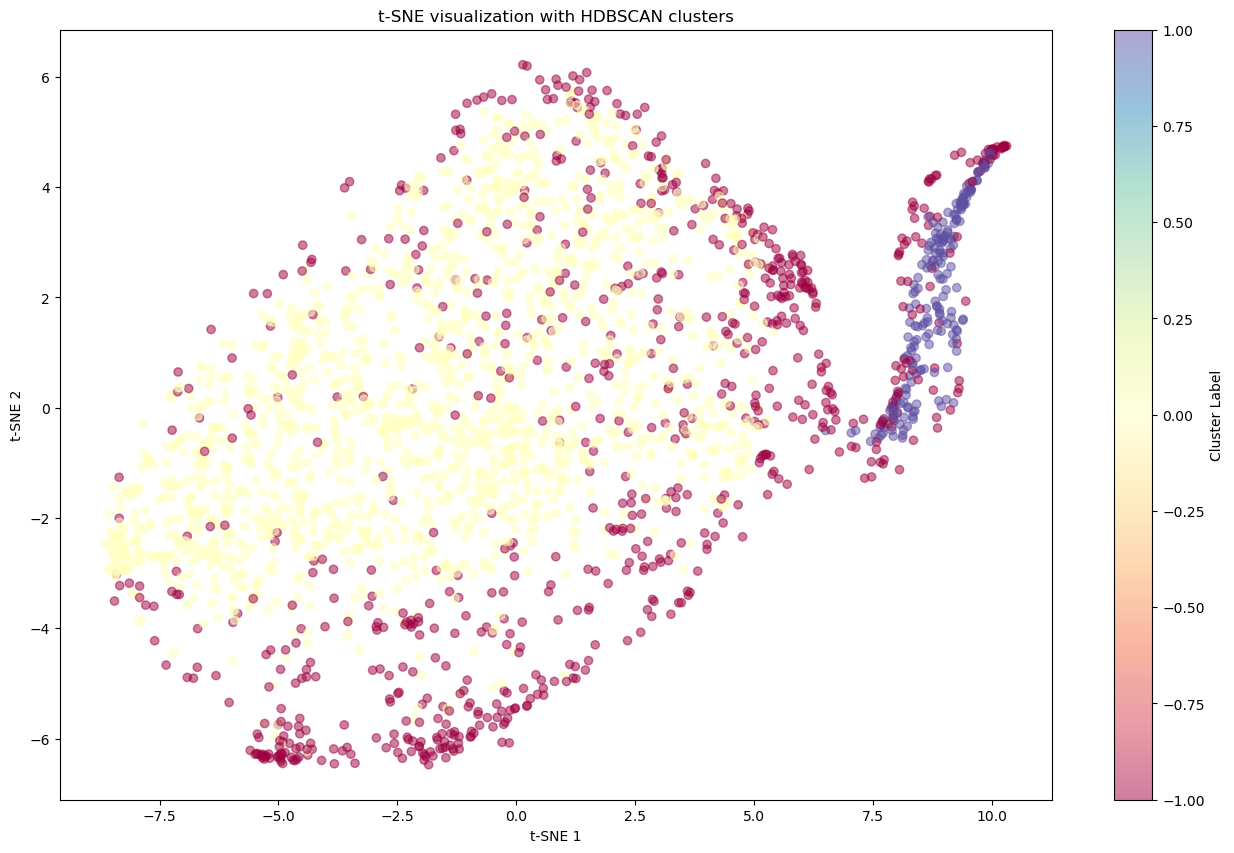

In [8]:
%matplotlib inline

embeddings_np = embeddings.detach().numpy()

# Perform PCA to reduce to 50 dimensions (change this later)
pca = PCA(n_components=50)
pca_result = pca.fit_transform(embeddings_np)

print(f'Explained variance ratio by PCA components: {pca.explained_variance_ratio_}')
print(f'Cumulative explained variance: {np.sum(pca.explained_variance_ratio_)}')


from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_result = tsne.fit_transform(pca_result)

# Plot t-SNE result
plt.figure(figsize=(16, 10))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.5)
plt.title('t-SNE visualization of BERT embeddings')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

# final step: HDBSCAN clustering
!pip install hdbscan
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
cluster_labels = clusterer.fit_predict(embeddings_np)

plt.figure(figsize=(16, 10))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=cluster_labels, cmap='Spectral', alpha=0.5)
plt.title('t-SNE visualization with HDBSCAN clusters')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar(label='Cluster Label')
plt.show()